In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import risk_models, expected_returns, EfficientFrontier, plotting, objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.cm as cm
import plotly.graph_objects as go

# Define the list of tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NFLX", "NVDA", "AMD", "INTC", "CSCO", "IBM", "ORCL", "QCOM", "TXN", "AAP", "AZN", "GOOG", "NVDA", "TSLA", "ADBE", "CRM"]

# Download historical data
data = yf.download(tickers, start="2020-01-01", end="2025-01-01")["Close"]
data = data.dropna()

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

[*********************100%***********************]  20 of 20 completed


In [24]:
# User choice: Max Sharpe (returns), Min Volatility (risk), Low Beta, or Target Return
choice = input("Choose portfolio objective (1 = Maximize Sharpe Ratio, 2 = Minimize Volatility, 3 = Low Beta Portfolio, 4 = Target Return): ")

if choice == '2':
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    title = "Portfolio Allocation - Minimum Volatility"
elif choice == '1':
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe()
    title = "Portfolio Allocation - Maximum Sharpe Ratio"
elif choice == '3':
    # Add low beta constraint
    betas = pd.DataFrame(index=tickers)
    # Download S&P 500 historical data
    sp500 = yf.Ticker("^GSPC")
    sp500_data = sp500.history(start="2020-01-01", end="2024-12-31")["Close"]
    sp500_returns = sp500_data.pct_change().dropna()

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        stock_data = stock.history(start="2020-01-01", end="2024-12-31")["Close"]
        stock_returns = stock_data.pct_change().dropna()
        beta = stock_returns.corr(sp500_returns) * stock_returns.std() / sp500_returns.std()
        betas.loc[ticker, 'beta'] = beta

    # Find portfolio with minimum beta
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # Add L2 regularization for better beta estimation
    try:
        ef.min_volatility()  # Relax the constraint to minimize volatility instead of setting a target
    except OptimizationError as e:
        print("Optimization failed. Relaxing constraints.")
        ef = EfficientFrontier(mu, S)  # Reinitialize and retry with fewer constraints
        ef.min_volatility()
    title = "Portfolio Allocation - Low Beta"
elif choice == '4':
    target_return = float(input("Enter the target return (e.g., 0.08 for 8%): "))
    ef = EfficientFrontier(mu, S)
    ef.efficient_return(target_return)
    title = f"Portfolio Allocation - Target Return {target_return * 100}%"
    
    # Clean weights and display
weights = ef.clean_weights()

# Display the title for the chosen objective
print(f"\nOptimized Portfolio Weights ({title}):")
for stock, weight in weights.items():
    print(f"{stock}: {weight:.2%}")




Optimized Portfolio Weights (Portfolio Allocation - Maximum Sharpe Ratio):
AAP: 0.00%
AAPL: 0.00%
ADBE: 0.00%
AMD: 0.00%
AMZN: 0.00%
AZN: 0.00%
CRM: 0.00%
CSCO: 0.00%
GOOG: 0.00%
GOOGL: 0.00%
IBM: 13.07%
INTC: 0.00%
META: 0.00%
MSFT: 0.00%
NFLX: 0.00%
NVDA: 66.76%
ORCL: 5.85%
QCOM: 0.00%
TSLA: 14.32%
TXN: 0.00%


In [25]:
# Pie Chart of Portfolio Allocation
# Filter out tickers with 0% weight
filtered_weights = {stock: weight for stock, weight in weights.items() if weight > 0}
filtered_labels = list(filtered_weights.keys())
filtered_sizes = list(filtered_weights.values())
filtered_colors = cm.tab20c(np.linspace(0, 1, len(filtered_weights)))

# Create an interactive pie chart using plotly
fig = go.Figure(data=[go.Pie(
    labels=filtered_labels,
    values=filtered_sizes,
    textinfo="percent",
    hoverinfo="label+percent",  # Display both label and percentage on hover
    marker=dict(colors=filtered_colors)
)])

# Add title to the chart
fig.update_layout(
    title=title,
    title_x=0.5,  # Center title
    title_y=0.95,
    margin=dict(t=50, b=50, l=50, r=100)  # Adjust the margins to fit legend
)

# Add a legend on the right side
fig.update_layout(
    legend=dict(
        x=1,  # Position legend to the right of the pie chart
        y=0.5,
        traceorder="normal",
        orientation="v",
        font=dict(size=12)
    )
)

# Show the plot
fig.show()

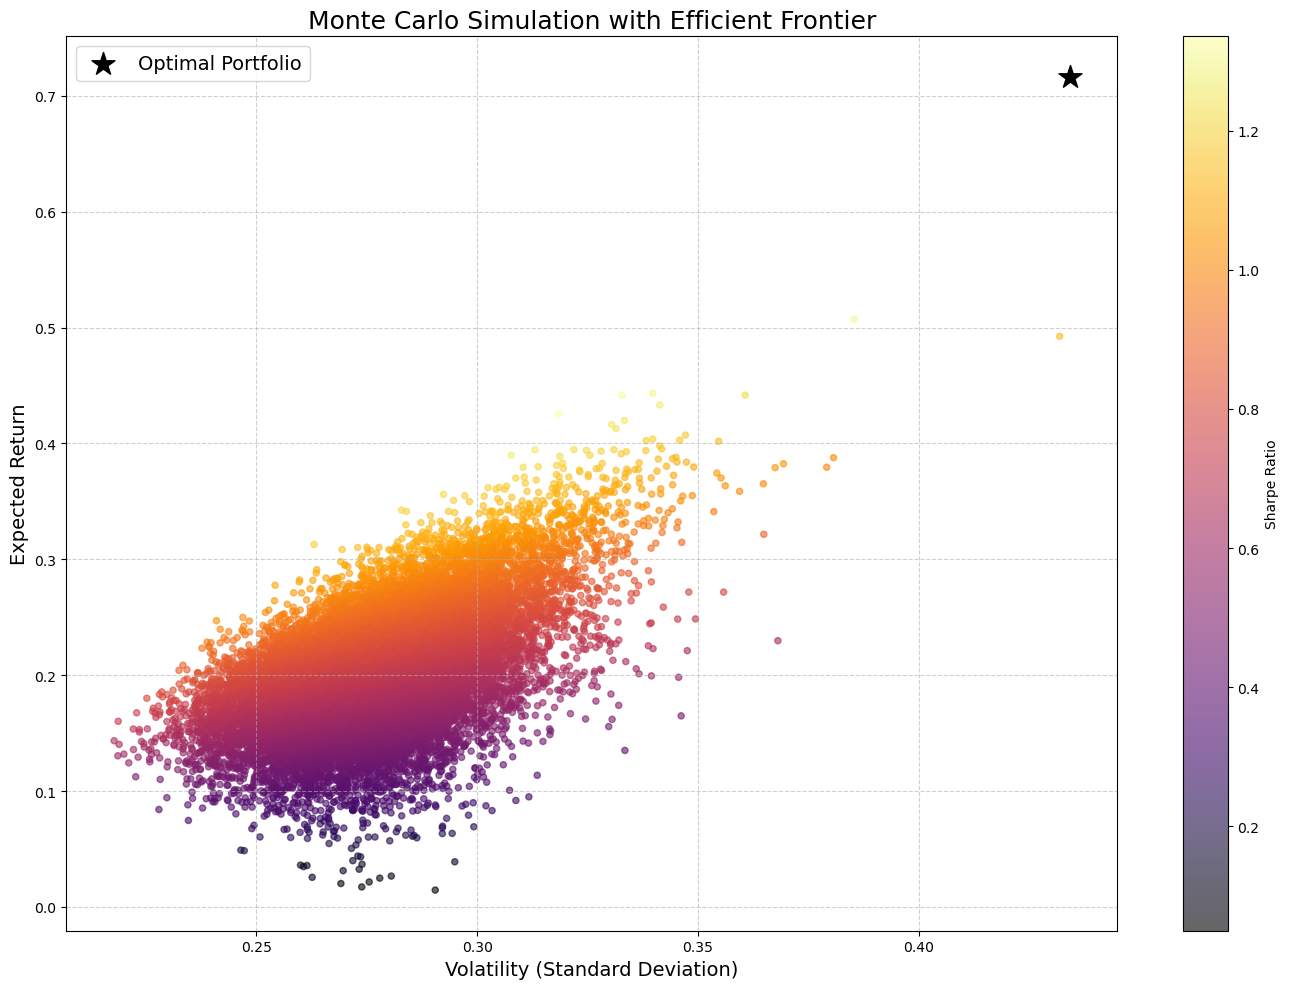

In [26]:
# Plot Monte Carlo simulation
num_portfolios = 20000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    # Random portfolio weights
    weights_i = np.random.dirichlet(np.ones(len(mu)))
    
    # Expected portfolio return
    ret = np.dot(weights_i, mu)
    
    # Portfolio volatility (standard deviation)
    vol = np.sqrt(np.dot(weights_i.T, np.dot(S, weights_i)))
    
    # Sharpe ratio (risk-adjusted return)
    sharpe = ret / vol
    
    # Store the results
    results[0, i] = vol
    results[1, i] = ret
    results[2, i] = sharpe

# Plot
plt.figure(figsize=(14, 10))  # Increase figure size for more space and clarity

# Scatter plot of results: X = volatility, Y = return, color = Sharpe ratio
# Increase the point size for better visibility, and reduce alpha to make the points more distinct
plt.scatter(results[0], results[1], c=results[2], cmap='inferno', marker='o', s=20, alpha=0.6)

# Add a color bar to show the Sharpe ratio range
plt.colorbar(label='Sharpe Ratio')

# Highlight the optimal portfolio (maximum Sharpe ratio portfolio)
performance = ef.portfolio_performance()
opt_volatility, opt_return = performance[1], performance[0]
plt.scatter(opt_volatility, opt_return, marker='*', color='black', s=300, label='Optimal Portfolio')

# Add title and axis labels
plt.title("Monte Carlo Simulation with Efficient Frontier", fontsize=18)
plt.xlabel("Volatility (Standard Deviation)", fontsize=14)
plt.ylabel("Expected Return", fontsize=14)

# Add grid, legend and adjust layout for better visualization
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
